In [1]:
import typing as t
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader

In [2]:
# @formatter:off
%matplotlib inline
# @formatter:on

In [3]:
torch.set_warn_always(True)

sns.set_theme()
plt.rcParams["figure.figsize"] = (8, 4)

In [4]:
DATA_DIR = Path("../data/")

CUDA = "cuda"
CPU = "cpu"
DEVICE = CUDA if torch.cuda.is_available() else CPU
print(f"Using {DEVICE.upper()} device")

Using CUDA device


## Предобработка данных и подготовка датасета

In [5]:
def na_stat(df: pd.DataFrame) -> pd.Series:
    stat = df.isna().sum()
    return stat[stat > 0]


def duplicates_stat(df: pd.DataFrame) -> pd.Series:
    return df[df.duplicated()].value_counts()


def get_categorical_columns(df: pd.DataFrame) -> pd.Index:
    return df.select_dtypes(object).columns


def get_numerical_columns(df: pd.DataFrame) -> pd.Index:
    return df.select_dtypes(np.number).columns


def count_categories(df: pd.DataFrame) -> pd.Series:
    return df[get_categorical_columns(df)].nunique()

In [6]:
concrete_df: pd.DataFrame = pd.read_csv(DATA_DIR / "regression/concrete.csv")
print(concrete_df.shape)
concrete_df.head()

(1030, 9)


,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [7]:
na_stat(concrete_df)

Series([], dtype: int64)

In [8]:
duplicates_stat(concrete_df)

Cement (component 1)(kg in a m^3 mixture)  Blast Furnace Slag (component 2)(kg in a m^3 mixture)  Fly Ash (component 3)(kg in a m^3 mixture)  Water  (component 4)(kg in a m^3 mixture)  Superplasticizer (component 5)(kg in a m^3 mixture)  Coarse Aggregate  (component 6)(kg in a m^3 mixture)  Fine Aggregate (component 7)(kg in a m^3 mixture)  Age (day)  strength
362.6                                      189.0                                                  0.0                                         164.9                                      11.6                                                 944.7                                                 755.8                                              3          35.30       3
                                                                                                                                                                                                                                                                             

In [9]:
concrete_df = concrete_df.drop_duplicates()
duplicates_stat(concrete_df)

Series([], dtype: int64)

In [10]:
print(concrete_df.shape)
concrete_df.head()

(1005, 9)


,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [11]:
class ConcreteDataset(Dataset):
    scaler: StandardScaler
    num_features: int
    data: torch.Tensor
    targets: torch.Tensor

    def __init__(self, df: pd.DataFrame, scaler: StandardScaler = None):
        if scaler:
            self.scaler = scaler
            scale = self.scaler.transform
        else:
            self.scaler = StandardScaler()
            scale = self.scaler.fit_transform

        target_col = "strength"
        data, targets = df.drop(columns=[target_col]), df[target_col]

        self.data = torch.tensor(scale(data), dtype=torch.float)
        self.targets = torch.tensor(targets.to_numpy(), dtype=torch.float).unsqueeze(1)
        self.num_features = self.data.size(1)

    def __len__(self):
        return self.targets.size(0)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

In [12]:
train_df, test_df = train_test_split(concrete_df, test_size=0.2, random_state=0)

train_dataset = ConcreteDataset(train_df)
test_dataset = ConcreteDataset(test_df, scaler=train_dataset.scaler)
len(train_dataset), len(test_dataset), train_dataset.num_features

(804, 201, 8)

## Построение и обучение модели

In [13]:
def common_train(
        model: nn.Module,
        loss_fn: nn.Module,
        optimizer: optim.Optimizer,
        epochs: int,
        train_dataloader: DataLoader,
        test_dataloader: DataLoader,
        verbose: int = None,
        device: str = CPU,
) -> t.Tuple[t.List[float], t.List[float], t.List[float], t.List[float]]:
    train_losses, train_r2s = [], []
    test_losses, test_r2s = [], []
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}\n" + "-" * 32)

        train_loss, train_r2 = train_loop(train_dataloader, model, loss_fn, optimizer, verbose=verbose, device=device)
        print(f"Train Error: loss: {train_loss:.6f}, R^2: {train_r2:.4f}")
        train_losses.append(train_loss)
        train_r2s.append(train_r2)

        test_loss, test_r2 = test_loop(test_dataloader, model, loss_fn, device=device)
        print(f" Test Error: loss: {test_loss:.6f}, R^2: {test_r2:.4f}\n")
        test_losses.append(test_loss)
        test_r2s.append(test_r2)

        torch.cuda.empty_cache()
    return train_losses, train_r2s, test_losses, test_r2s


def train_loop(
        dataloader: DataLoader,
        model: nn.Module,
        loss_fn: nn.Module,
        optimizer: optim.Optimizer,
        verbose: int = None,
        device: str = CPU,
) -> t.Tuple[float, float]:
    model.train()

    size = len(dataloader.dataset)  # noqa
    num_batches = len(dataloader)
    avg_loss, avg_r2 = 0, 0

    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)

        pred = model(x)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        r2 = metrics.r2_score(y.detach().cpu(), pred.detach().cpu())
        avg_loss += loss
        avg_r2 += r2
        if verbose and batch % verbose == 0:
            print(f"[{batch * len(x):>4d}/{size:>4d}]: loss: {loss:.6f}, R^2: {r2:.4f}")

        del x, y, pred, loss
        torch.cuda.empty_cache()

    return (avg_loss / num_batches).item(), avg_r2 / num_batches


@torch.no_grad()
def test_loop(
        dataloader: DataLoader,
        model: nn.Module,
        loss_fn: nn.Module,
        device: str = CPU,
) -> t.Tuple[float, float]:
    model.eval()
    y_true, y_pred = get_y_true_y_pred(model, dataloader, device)
    return loss_fn(y_pred, y_true).item(), metrics.r2_score(y_true, y_pred)


@torch.no_grad()
def get_y_true_y_pred(
        model: nn.Module,
        dataloader: DataLoader,
        device: str = CPU,
) -> t.Tuple[torch.Tensor, torch.Tensor]:
    model.eval()

    y_test = []
    y_pred = []
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        pred = model(x)
        y_test.append(y)
        y_pred.append(pred)

        del x
        torch.cuda.empty_cache()

    return torch.flatten(torch.vstack(y_test)).cpu(), torch.flatten(torch.vstack(y_pred)).cpu()


def plot_train_test(
        train_losses: t.List[float],
        train_r2s: t.List[float],
        test_losses: t.List[float],
        test_r2s: t.List[float],
) -> None:
    fig, axes = plt.subplots(2, 1, figsize=(6, 7))
    epochs = torch.arange(len(train_losses))

    axes[0].plot(epochs, train_losses)
    axes[0].plot(epochs, test_losses)
    axes[0].set_ylabel("loss")
    axes[0].legend(["train", "test"])

    axes[1].plot(epochs, train_r2s)
    axes[1].plot(epochs, test_r2s)
    axes[1].set_xlabel("epoch")
    axes[1].set_ylabel("$R^2$")


def plot_y_true_y_pred(y_true: torch.Tensor, y_pred: torch.Tensor):
    x = torch.arange(len(y_pred))
    plt.plot(x, y_true)
    plt.plot(x, y_pred)
    plt.legend(["true", "pred"])

In [14]:
class ConcreteRegression(nn.Module):

    def __init__(self, num_features: int):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(num_features, 128),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(256, 1),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.mlp(x)

In [15]:
torch.manual_seed(0)

net = ConcreteRegression(train_dataset.num_features).to(DEVICE)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.003)

train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset))

net

ConcreteRegression(
  (mlp): Sequential(
    (0): Linear(in_features=8, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=128, out_features=512, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.25, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.25, inplace=False)
    (9): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [16]:
%%time

train_losses, train_r2s, test_losses, test_r2s = common_train(
    epochs=200,
    model=net,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    device=DEVICE,
)

Epoch 1
--------------------------------
Train Error: loss: 1131.776855, R^2: -3.3057
 Test Error: loss: 303.685211, R^2: -0.1578

Epoch 2
--------------------------------
Train Error: loss: 393.433014, R^2: -0.5126
 Test Error: loss: 229.841431, R^2: 0.1237

Epoch 3
--------------------------------
Train Error: loss: 297.364319, R^2: -0.1365
 Test Error: loss: 190.612595, R^2: 0.2733

Epoch 4
--------------------------------
Train Error: loss: 232.799042, R^2: 0.1307
 Test Error: loss: 149.820160, R^2: 0.4288

Epoch 5
--------------------------------
Train Error: loss: 193.440994, R^2: 0.2523
 Test Error: loss: 173.853622, R^2: 0.3372

Epoch 6
--------------------------------
Train Error: loss: 191.358948, R^2: 0.2615
 Test Error: loss: 149.411224, R^2: 0.4304

Epoch 7
--------------------------------
Train Error: loss: 168.232544, R^2: 0.3401
 Test Error: loss: 138.122101, R^2: 0.4734

Epoch 8
--------------------------------
Train Error: loss: 149.917175, R^2: 0.3947
 Test Error: lo

## Оценка и выводы

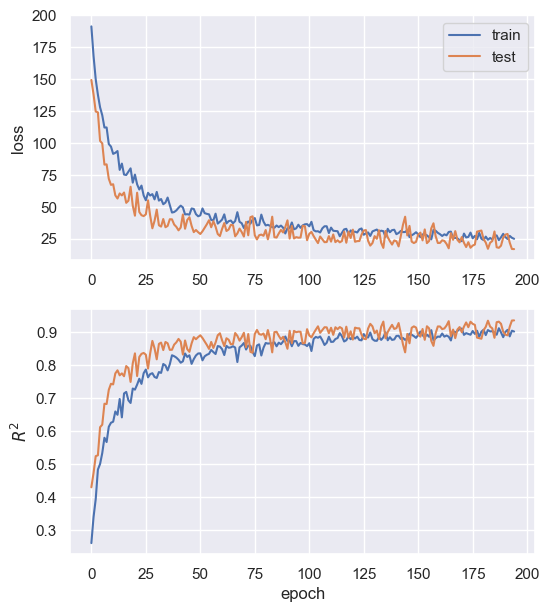

In [17]:
plot_train_test(train_losses[5:], train_r2s[5:], test_losses[5:], test_r2s[5:])

In [18]:
y_true, y_pred = get_y_true_y_pred(net, test_dataloader, DEVICE)

r2 = metrics.r2_score(y_true, y_pred)
mse = metrics.mean_squared_error(y_true, y_pred)  # тоже самое что и nn.MSELoss
rmse = np.sqrt(mse)
mae = metrics.mean_absolute_error(y_true, y_pred)
mape = metrics.mean_absolute_percentage_error(y_true, y_pred)
rmsle = np.sqrt(metrics.mean_squared_log_error(y_true, y_pred))
print(f"  R^2: {r2:.6f}")
print(f"  MSE: {mse:.6f}")
print(f" RMSE: {rmse:.6f}")
print(f"  MAE: {mae:.6f}")
print(f" MAPE: {mape:.6f}")
print(f"RMSLE: {rmsle:.6f}")

  R^2: 0.935394
  MSE: 16.945608
 RMSE: 4.116504
  MAE: 3.149045
 MAPE: 0.114794
RMSLE: 0.143966


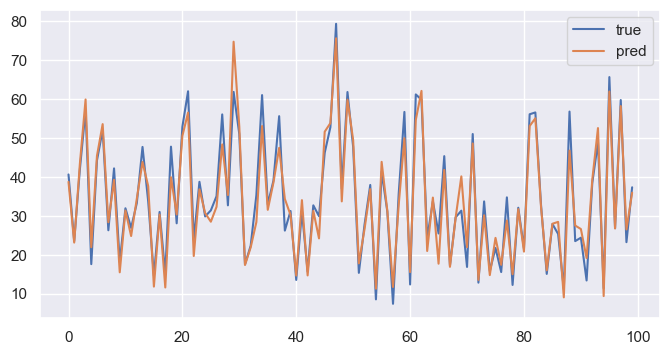

In [19]:
plot_y_true_y_pred(y_true[:100], y_pred[:100])

In [20]:
net.eval()
for i in torch.randperm(len(test_dataset))[:5]:
    x, y = test_dataset[i]
    x, y = x.to(DEVICE), y.to(DEVICE)
    pred = net(x.unsqueeze(0)).squeeze(0)
    print(f"Input:   {x.cpu()}")
    print(f"Target:  {y.item():.6f}")
    print(f"Predict: {pred.item():.6f}\n")

Input:   tensor([-1.2053, -0.8320,  1.3913,  0.5390,  0.4883, -1.2832,  1.1686, -0.2872])
Target:  9.740000
Predict: 13.208205

Input:   tensor([ 0.3272, -0.8320,  0.9182, -0.5532,  0.6524, -0.6564,  0.1257, -0.2872])
Target:  38.459999
Predict: 39.307152

Input:   tensor([-0.1316,  0.4516,  0.5249, -0.1798,  0.7016, -0.8597, -0.3466, -0.2872])
Target:  39.419998
Predict: 42.320850

Input:   tensor([-1.3518,  1.5615, -0.8459,  0.4783, -1.0051,  0.9295,  0.4209, -0.6198])
Target:  14.590000
Predict: 9.720526

Input:   tensor([-1.3123,  1.1134,  1.2315,  0.4597,  0.3898, -2.1055,  0.4012, -0.2872])
Target:  29.870001
Predict: 30.737513

